In [1]:
import torch
import torch.nn as nn
from NARX import NARX
from ANARX import ANARX
import matplotlib.pyplot as plt
from tqdm import tqdm
from utilities import lag_matrix
from sysidentpy.utils.generate_data import get_siso_data
import scipy.io

from pathlib import Path
print(Path.cwd())


c:\Users\vh\Documents\Projektmodul\Valentin macht alles neu\unified


In [76]:
# model = ANARX(5, [1, 1])
# optim = torch.optim.Adam(model.parameters())
# crit = nn.MSELoss()
# x_train, x_valid, y_train, y_valid = get_siso_data(n=1000,
#                                                    colored_noise=False,
#                                                    sigma=0.01,
#                                                    train_percentage=80)
data = scipy.io.loadmat("data/1803")
in1 = data["u1_t"]
in2 = data["u2_t"]
out = data["y_t"]

In [77]:
model2 = ANARX(5, [2, 2], n_hidden=5, layersize= 20)

In [78]:
out = torch.Tensor(out).squeeze()
in1 = torch.Tensor(in1).squeeze()
in2 = torch.Tensor(in2).squeeze()
in1_lagged = lag_matrix(in1, 2)
out_lagged = lag_matrix(out, 5)
in2_lagged = lag_matrix(in2, 2)

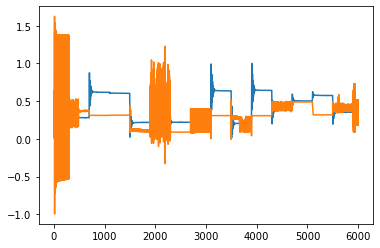

In [94]:
plt.plot(out.detach().numpy())
plt.plot(model2.predict([in1, in2]).detach().numpy())
plt.show()

In [89]:
# Closed Loop Training
optim = torch.optim.Adam(model2.parameters())
crit = nn.MSELoss()
for i in tqdm(range(10)):
    optim.zero_grad()
    pred = model2.predict([in1, in2])
    loss = crit(pred, out)
    loss.backward()
    optim.step()

100%|██████████| 10/10 [02:45<00:00, 16.50s/it]


In [93]:
# Open Loop Training
optim = torch.optim.Adam(model2.parameters())
crit = nn.MSELoss()
dataset = torch.utils.data.TensorDataset(in1_lagged, in2_lagged, out_lagged, out)
loader = torch.utils.data.DataLoader(dataset, batch_size=2000, shuffle=False)
for epoch in tqdm(range(1000)):
    for i1, i2, ol, os in loader:
        optim.zero_grad()
        result = model2(ol, [i1, i2])
        # print(result)
        loss = crit(result, os)
        loss.backward()
        optim.step()

100%|██████████| 1000/1000 [02:47<00:00,  5.98it/s]
